In [1]:
import pandas as pd
df = pd.read_pickle('data/intersection_of_visits.pkl')
#df = pd.read_pickle('data/intersection_cmps_succeeded_only.pkl')
#df = pd.read_pickle('data/all_cmps_succeeded.pkl')

Put visits into four different catagories based on consent mode and whether sendBeacon was used.

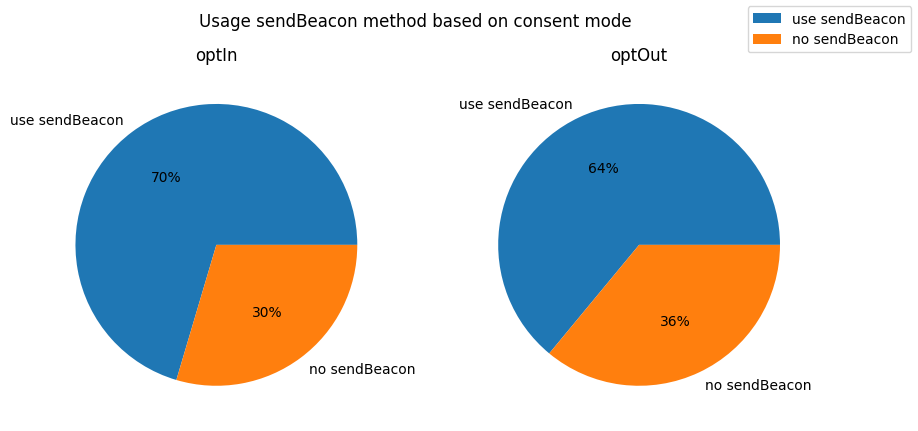

In [2]:
df_filtered = df.copy()
def test(row):
    if row['apis'] == {'callStats': {}, 'savedCalls': []}:
        if row['autoconsent_action'] == 'optIn':
            return 'no sendBeacon optIn'
        else:
            return 'no sendBeacon optOut'
    elif row['apis'] == None:
        if row['autoconsent_action'] == 'optIn':
            return 'no sendBeacon optIn'
        else:
            return 'no sendBeacon optOut'
    else:
        if row['autoconsent_action'] == 'optIn':
            return 'sendBeacon optIn'
        else:
            return 'sendBeacon optOut'

df_filtered['sendBeacon_category'] = df_filtered.apply(lambda row: test(row), axis=1)
category_counts = df_filtered['sendBeacon_category'].value_counts()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].pie([category_counts['sendBeacon optIn'], category_counts['no sendBeacon optIn']], autopct='%.0f%%', labels=['use sendBeacon', 'no sendBeacon'])
ax[0].set_title("optIn")
ax[1].pie([category_counts['sendBeacon optOut'], category_counts['no sendBeacon optOut']], autopct='%.0f%%', labels=['use sendBeacon', 'no sendBeacon'])
ax[1].set_title("optOut")

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Usage sendBeacon method based on consent mode")
fig.set_figwidth(10)
plt.show()

Filter out all visits that don't have a sendBeacon call.

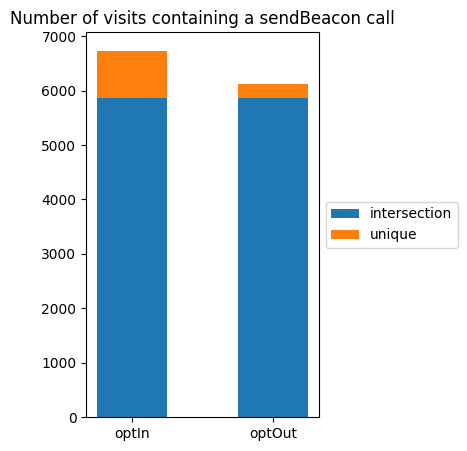

In [3]:
df_filtered = df_filtered[df_filtered['sendBeacon_category'].isin(['sendBeacon optIn', 'sendBeacon optOut'])].copy()

df_filtered_optIn = df_filtered[df_filtered['autoconsent_action'] == 'optIn']
df_filtered_optOut = df_filtered[df_filtered['autoconsent_action'] == 'optOut']

import numpy as np
intersect = np.intersect1d(df_filtered_optIn['initialUrl'], df_filtered_optOut['initialUrl'])

df_intersection = df_filtered[df_filtered['initialUrl'].isin(intersect)]

sums = [len(df_filtered_optIn), len(df_filtered_optOut), len(intersect)]
intersect_size = len(intersect)
sums = {
    "intersection": np.array([intersect_size]*2),
    "unique": np.array([len(df_filtered_optIn)-intersect_size, len(df_filtered_optOut)-intersect_size]),
}
labels = ['optIn', 'optOut']

fig, ax = plt.subplots(figsize=(3,5))
bottom = np.zeros(2)

for boolean, sum in sums.items():
    p = ax.bar(labels, sum, width=0.5, label=boolean, bottom=bottom)
    bottom += sum

ax.set_title("Number of visits containing a sendBeacon call")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

Unfold the api column and remove unnecessary columns.

In [4]:
sources = []
arguments = []

def create_list(row):
    if row:
        if row['savedCalls']:
            return row['savedCalls']
    return [{}]

df_exploded = df_intersection.copy()
df_exploded['apis'] = df_exploded['apis'].map(lambda x: create_list(x))
df_exploded = df_exploded.explode('apis')

def get_sources(row):
    if row['apis']:
        if row['apis']['source']:
            return row['apis']['source']
    return ''

df_exploded['source'] = df_exploded.apply(lambda x: get_sources(x), axis=1)

def get_first_argument(row):
    if row['apis']:
        if row['apis']['arguments']:
            return row['apis']['arguments'][0]
    return []

df_exploded['target'] = df_exploded.apply(lambda x: get_first_argument(x), axis=1)

def get_second_argument(row):
    if row['apis']:
        if row['apis']['arguments']:
            if len(row['apis']['arguments']) > 1:
                return row['apis']['arguments'][1]
    return []

df_exploded['argument'] = df_exploded.apply(lambda x: get_second_argument(x), axis=1)

df_exploded = df_exploded.drop(['cmps', 'requests', 'apis', 'sendBeacon_category', 'cookies', 'targets'], axis=1)

print("nr rows that contain argument: " + str(df_exploded['argument'].apply(lambda x: len(x) > 0).values.sum()))

display(df_exploded)

nr rows that contain argument: 45601


,initialUrl,finalUrl,autoconsent_action,source,target,argument
2,http://bstatic.com/,https://www.booking.com/index.en-gb.html?label...,optIn,https://cf.bstatic.com/static/js/main_cloudfro...,https://www.booking.com/js_tracking?lang=en-gb...,[]
2,http://bstatic.com/,https://www.booking.com/index.en-gb.html?label...,optIn,https://www.googletagmanager.com/gtm.js?id=GTM...,https://www.google.com/pagead/landing?gcs=G11-...,[]
2,http://bstatic.com/,https://www.booking.com/index.en-gb.html?label...,optIn,https://www.googletagmanager.com/gtag/js?id=G-...,https://region1.analytics.google.com/g/collect...,[]
2,http://bstatic.com/,https://www.booking.com/index.en-gb.html?label...,optIn,https://www.googletagmanager.com/gtag/js?id=G-...,https://stats.g.doubleclick.net/g/collect?v=2&...,[]
2,http://bstatic.com/,https://www.booking.com/index.en-gb.html?label...,optIn,https://sc-static.net/scevent.min.js,https://tr.snapchat.com/p,"{""ctx"":{""bt"":""1d53c387"",""c1"":""fd2b9937-426b-40..."
...,...,...,...,...,...,...
9615,http://qortex.ai/,https://www.qortex.ai/,optOut,https://f.vimeocdn.com/js_opt/modules/utils/vu...,https://vimeo.com/ablincoln/vuid?pid=cae73d017...,[]
9615,http://qortex.ai/,https://www.qortex.ai/,optOut,https://www.googletagmanager.com/gtag/js?id=G-...,https://region1.analytics.google.com/g/collect...,[]
9615,http://qortex.ai/,https://www.qortex.ai/,optOut,https://www.googletagmanager.com/gtag/js?id=G-...,https://region1.analytics.google.com/g/collect...,[]
9617,http://mozilla.org/,https://www.mozilla.org/,optOut,https://www.googletagmanager.com/gtag/js?id=G-...,https://region1.google-analytics.com/g/collect...,[]


In [6]:
#df_first_party = df_exploded.query('finalUrl == source')
df_same_url = df_exploded[df_exploded.apply(lambda row: row['finalUrl'] == row['source'], axis=1)]
from urllib.parse import urlsplit
df_first_party = df_exploded[df_exploded.apply(lambda row: urlsplit(row['finalUrl']).netloc == urlsplit(row['source']).netloc, axis=1)]
#split_url = urlsplit()
#df_google = df_exploded[df_exploded['initialUrl'].str.contains('bstatic')]
#df_no_argument = df_exploded[df_exploded['argument'].str.len() == 0].copy()
#df_argument = df_exploded[df_exploded['argument'].str.len() > 0].copy()

#display(df_same_url)
#display(df_first_party)
#print(df_exploded.groupby('initialUrl').ngroups)
#print(df_first_party.groupby('initialUrl').ngroups)

attributes = {
    'device_user_agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36",
    'viewport_width': "800",
    'viewport_height': "600",
    'plugins': "Chrome PDF Plugin",
    'encoding': "gzip, deflate, br",
    'platform': "Linux x86_64",
    'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    'gl version': "WebGL 1.0 (OpenGL ES 2.0 Chromium)",
    'hardware concurrency': "24",
}

def contains_fingerprint(row, attributes):
    row_data = "".join(row['target']) + "".join(row['argument'])
    nr_attributes = 0
    for attribute in attributes:
        if attributes[attribute] in row_data:
            nr_attributes += 1
    return nr_attributes

df_exploded['attributes_count'] = df_exploded.apply(lambda row: contains_fingerprint(row, attributes), axis=1)
print(df_exploded.attributes_count.value_counts())
df_exploded[df_exploded['attributes_count'] > 3].groupby(['initialUrl', 'autoconsent_action']).count()

attributes_count
0    54281
2    22263
3    12344
1    10992
4      756
5        7
6        4
7        1
Name: count, dtype: int64


finalUrl  source  target  \
initialUrl               autoconsent_action                             
http://accorhotels.com/  optIn                      1       1       1   
http://adsmoloco.com/    optIn                      1       1       1   
http://ae.com/           optIn                      4       4       4   
                         optOut                     4       4       4   
http://aeon.co.jp/       optIn                      1       1       1   
...                                               ...     ...     ...   
http://yorku.ca/         optIn                      2       2       2   
http://zennioptical.com/ optIn                      4       4       4   
                         optOut                     1       1       1   
http://zoopla.co.uk/     optIn                      1       1       1   
                         optOut                     1       1       1   

                                             argument  attributes_count  
initialUrl               autoconsent_action                              
http://accorhotels.com/  optIn                      1                 1  
http://adsmoloco.com/    optIn                      1                 1  
http://ae.com/           optIn                      4                 4  
                         optOut                     4                 4  
http://aeon.co.jp/       optIn                      1                 1  
...                                               ...               ...  
http://yorku.ca/         optIn                      2                 2  
http://zennioptical.com/ optIn                      4                 4  
                         optOut                     1                 1  
http://zoopla.co.uk/     optIn                      1                 1  
                         optOut                     1                 1  

[425 rows x 5 columns]